# ENPM808W: HW3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
cwd = os.getcwd()
train_data_path = os.path.join(cwd, 'Quiz_bowl_data', 'qb.train.csv')
test_data_path = os.path.join(cwd, 'Quiz_bowl_data', 'qb.test.csv')

## Load and preview Data

In [3]:
train_data = pd.read_csv(train_data_path)
train_data.head()

,row,body_score,page,answer,text,category,tournaments,answer_type,corr,inlinks
0,1,127.398036,Comus (John Milton),Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,work,True,62
1,2,50.212336,Circe,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,5
2,3,44.767071,Satyr,Comus (John Milton),First performed in Ludlow Castle by the childr...,Literature,2000 ACF Nationals,None,False,6
3,4,44.058274,Philip K. Dick,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,people,False,22
4,5,40.675249,Honore de Balzac,Wilfred Owen,This author is convinced by another to publish...,Literature,2009 ACF Winter,None,False,0


In [4]:
test_data = pd.read_csv(test_data_path)
test_data.head()

,row,body_score,page,text,category,tournaments,answer_type,inlinks
0,31,40.023617,Death in Venice,The protagonist of this novella is inspired to...,Literature,2001 ACF Fall,work,4
1,32,27.538799,The Eye of the World,The protagonist of this novella is inspired to...,Literature,2001 ACF Fall,work,1
2,33,26.976121,Carmilla,The protagonist of this novella is inspired to...,Literature,2001 ACF Fall,work,2
3,88,45.848831,A Passage to India,In a symbolic incident in this novel Ronny Hea...,Literature,2001 ACF Regionals,work,5
4,91,99.811169,The Cherry Orchard,"We first meet Fiers, the aging footman, in Act...",Literature,2001 ACF Regionals,work,11


## Information about data

In [5]:
train_data.describe()

,row,body_score,inlinks
count,8079.000000,8079.000000,8079.000000
mean,6925.462805,58.712909,70.683253
std,4010.872917,40.023035,541.807126
min,1.000000,0.000000,0.000000
25%,3500.500000,32.073499,4.000000
50%,6905.000000,49.067585,15.000000
75%,10370.500000,71.922447,45.000000
max,13924.000000,359.077342,43182.000000


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8079 entries, 0 to 8078
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row          8079 non-null   int64  
 1   body_score   8079 non-null   float64
 2   page         8079 non-null   object 
 3   answer       8079 non-null   object 
 4   text         8079 non-null   object 
 5   category     8079 non-null   object 
 6   tournaments  8079 non-null   object 
 7   answer_type  8079 non-null   object 
 8   corr         8079 non-null   bool   
 9   inlinks      8079 non-null   int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 576.1+ KB


## Value counts for categorical data

In [7]:
train_data['answer_type'].value_counts()

people    3051
work      2895
None      1617
char       293
place       71
org         68
abs         46
event       19
anim        19
Name: answer_type, dtype: int64

In [8]:
train_data['corr'].value_counts()

False    4478
True     3601
Name: corr, dtype: int64

In [9]:
train_data['category'].value_counts()

Literature    8079
Name: category, dtype: int64

In [10]:
train_data['tournaments'].value_counts()

2007 Chicago Open Literature Singles           375
2008 Chicago Open Literature Singles           328
2007 Illinois Open Literature Doubles          273
2001 ACF Regionals                             167
1999 ACF Regionals                             166
                                              ... 
2008 The July Crisis                             9
2010 Mildly Experimental Literature Doubles      5
2010 Penn Bowl                                   4
2010 Chicago Open                                3
2009 Missouri Open                               3
Name: tournaments, Length: 76, dtype: int64

## Answer 2.  Classifier using existing data

## Exploratory data analysis

### 1. Distribution of body score

* We can see that a high body score correlates to a correct answer

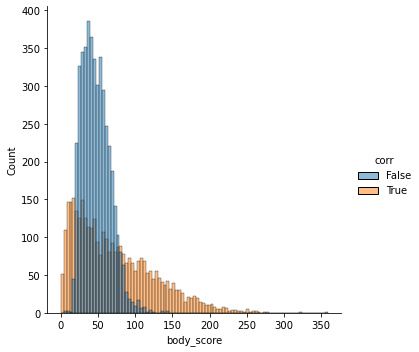

In [11]:
ax1 = sns.displot(data=train_data, x='body_score', hue='corr')

### 2. Distribution of answer type

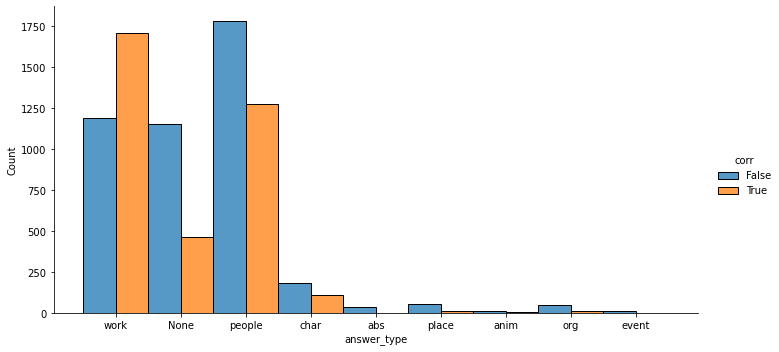

In [12]:
ax2 = sns.displot(data=train_data, x='answer_type', hue='corr', multiple='dodge', height=5, aspect=2)

### 3. Check if distribution of body score varies by answer type

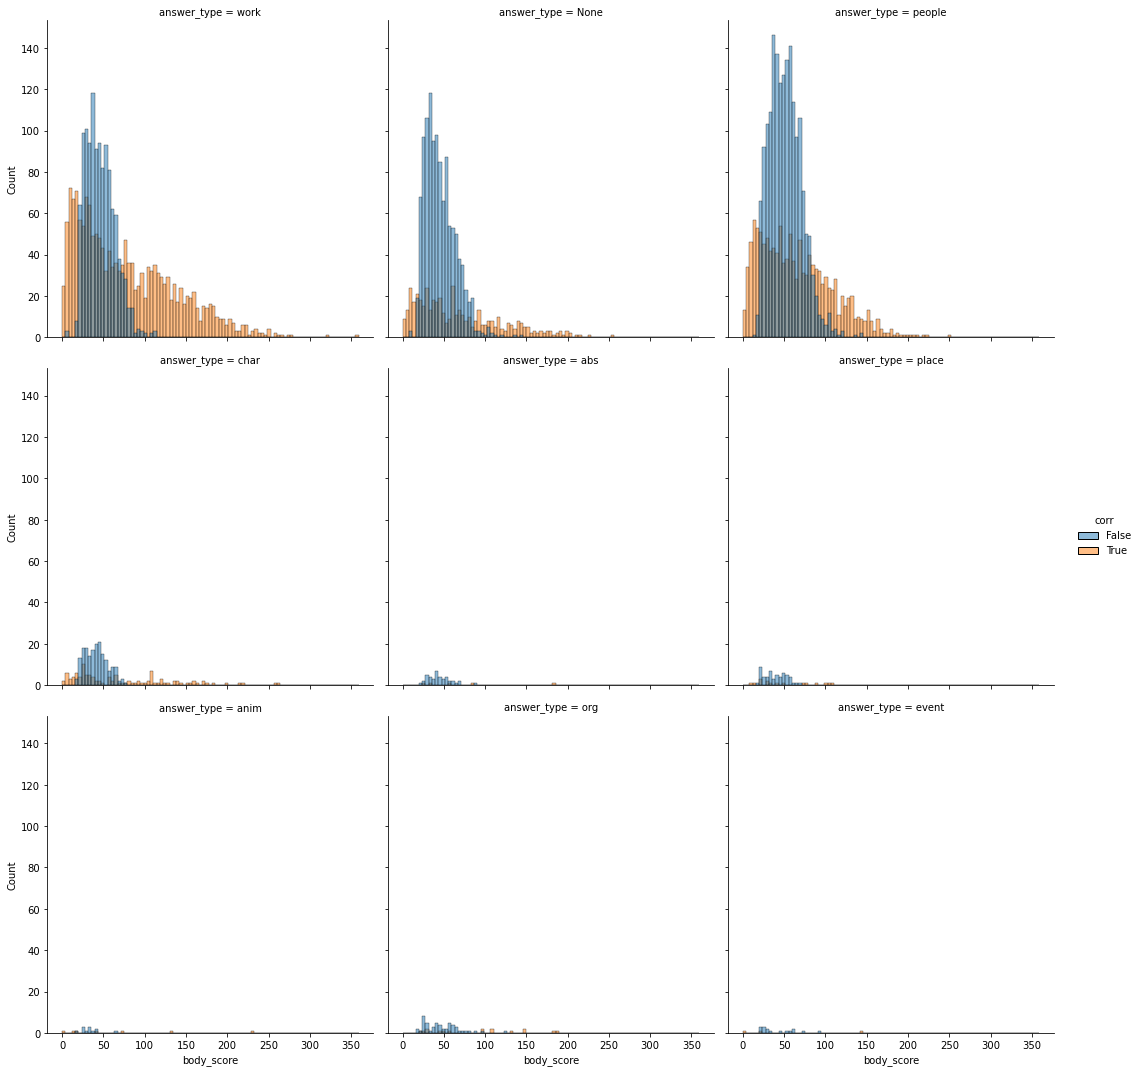

In [13]:
ax3 = sns.displot(data=train_data, x='body_score', hue='corr', col='answer_type', col_wrap=3)

### 4. Distribution of inlinks

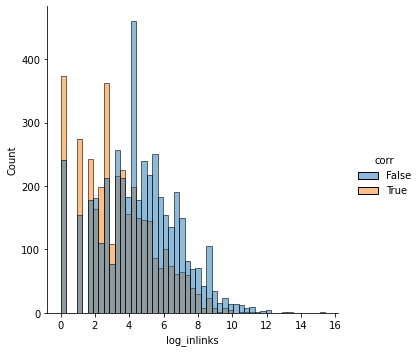

In [14]:
train_data['inlinks']+=1
train_data['log_inlinks'] = np.log2(train_data['inlinks'])
ax4 = sns.displot(data=train_data, x='log_inlinks', hue='corr')

## Classifier using existing data -- Split into train/ dev data

* I'm using the following columns in my training data -- 1) log of inlinks 2) body_score
* I've split the training data into test and dev using in the ratio of 80-20.

In [15]:
num_train = train_data.shape[0]
train_x = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['log_inlinks', 'body_score'])
train_y = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['corr'])
dev_x = pd.DataFrame(train_data[int(0.8*num_train):], columns=['log_inlinks', 'body_score'])
dev_y = pd.DataFrame(train_data[int(0.8*num_train):], columns=['corr'])

### 1. Logistic Regression

In [16]:
# fit model
logistic_model = LogisticRegression()
logistic_model.fit(train_x, train_y)

# prediction
y_pred = logistic_model.predict(dev_x)

# confusion matrix
cm = confusion_matrix(dev_y, y_pred)
accuracy = accuracy_score(dev_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# print results
print("Confusion matrix: \n {} \n".format(cm))
print("The accuracy score: {} \n".format(accuracy))
print('True negatives : {}'.format(tn))
print('False positives : {}'.format(fp))
print('False negatives : {}'.format(fn))
print('True positives : {}'.format(tp))

Confusion matrix: 
 [[726 183]
 [354 353]] 

The accuracy score: 0.6676980198019802 

True negatives : 726
False positives : 183
False negatives : 354
True positives : 353


/Users/gauharbains/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### 2. SVM

In [17]:
# fit model
svm_model = SVC()
svm_model.fit(train_x, train_y)

# prediction
y_pred = svm_model.predict(dev_x)

# confusion matrix and accuracy
cm = confusion_matrix(dev_y, y_pred)
accuracy = accuracy_score(dev_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# print results
print("Confusion matrix: \n {} \n".format(cm))
print("The accuracy score: {} \n".format(accuracy))
print('True negatives : {}'.format(tn))
print('False positives : {}'.format(fp))
print('False negatives : {}'.format(fn))
print('True positives : {}'.format(tp))

/Users/gauharbains/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion matrix: 
 [[866  43]
 [312 395]] 

The accuracy score: 0.7803217821782178 

True negatives : 866
False positives : 43
False negatives : 312
True positives : 395


### 3. Decision Trees

In [18]:
# fit model
tree_model = DecisionTreeClassifier()
tree_model.fit(train_x, train_y)

# prediction
y_pred = tree_model.predict(dev_x)

# confusion matrix
cm = confusion_matrix(dev_y, y_pred)
accuracy = accuracy_score(dev_y, y_pred)
tn, fp, fn, tp = cm.ravel()

# print results
print("Confusion matrix: \n {} \n".format(cm))
print("The accuracy score: {} \n".format(accuracy))
print('True negatives : {}'.format(tn))
print('False positives : {}'.format(fp))
print('False negatives : {}'.format(fn))
print('True positives : {}'.format(tp))

Confusion matrix: 
 [[626 283]
 [222 485]] 

The accuracy score: 0.6875 

True negatives : 626
False positives : 283
False negatives : 222
True positives : 485


## Results

* As stated earlier, the training data was split into train and dev in the ratio of 80/20
* The performance of the classifier was analyzed on the dev data.
* SVM classifier gives us the best performance -- with an accuracy score of 0.783. 
* Decision trees are second best at 0.684 followed by logistic regression at 0.67.
* From the confusion matrix we can see that in each case a high number of false negatives is affecting the accuracy score.   
  For example in the SVM classifier the ratio of false positives to false negatives is 1:8. 

## Answer 3. Finding additional features from given data

### 1.   Feature : length of text revealed

This can help us improve our prediction as intuitively the length of text revealed should have relation with whether the guess is correct or not.   
Cases where a large proportion of the questions is revealed should have better guesses. 

In [19]:
train_data['len_text'] = [ len(i.split(' ')) for i in train_data['text']]
test_data['len_text'] = [ len(i.split(' ')) for i in test_data['text']]

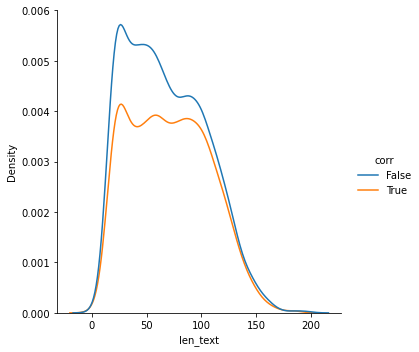

In [20]:
ax4 = sns.displot(data=train_data, x='len_text', hue='corr', kind='kde')

### 2. Feature: Ratio of len_text and inlinks

* To create a new feature out of the existing data -- I took ratio of len_text revealed to the number of inlinks on the guessed wikipedia page. 
* The intuition behind this is that greater the amount of text revealed, higher the chance that the ansewr is correct. On the other hand, lesser number of
  inlinks in the guessed wikipedia page attribute to a higher chance that the answer is correct.
* Combining these two into a single feature -- a higher value if this new feature should indicate a higher chance that a guess is correct and vice versa.   
  This is because length of text is in the numerator and number of inlinks is in the denominator. 


In [21]:
train_data['new_feature'] = [train_data['len_text'][i]/(train_data['inlinks'][i]+1) for i in range(len(train_data['inlinks']))]

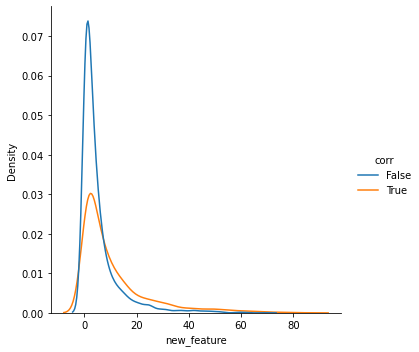

In [22]:
ax4 = sns.displot(data=train_data, x='new_feature', hue='corr', kind='kde')

### Training a classifier using only this feature

In [23]:
train_x = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['new_feature'])
train_y = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['corr'])
dev_x = pd.DataFrame(train_data[int(0.8*num_train):], columns=['new_feature'])
dev_y = pd.DataFrame(train_data[int(0.8*num_train):], columns=['corr'])


In [24]:
# fit model
model = SVC()
model.fit(train_x, train_y)

# prediction
y_pred = model.predict(dev_x)
y_train_pred = model.predict(train_x)

# confusion matrix
accuracy = accuracy_score(dev_y, y_pred)
accuracy_train = accuracy_score(train_y, y_train_pred)

print("The accuracy score in dev data: {}".format(accuracy))
print("The accuracy score on train data: {} \n".format(accuracy_train))

/Users/gauharbains/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The accuracy score in dev data: 0.6373762376237624
The accuracy score on train data: 0.6244777966888442 



### Training a classifier using this feature in combination with other features from part 1

In [25]:
train_x = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['log_inlinks', 'body_score', 'new_feature'])
train_y = pd.DataFrame(train_data[:int(0.8*num_train)], columns=['corr'])
dev_x = pd.DataFrame(train_data[int(0.8*num_train):], columns=['log_inlinks', 'body_score', 'new_feature'])
dev_y = pd.DataFrame(train_data[int(0.8*num_train):], columns=['corr'])

In [26]:
# fit model
model = SVC()
model.fit(train_x, train_y)

# prediction
y_pred = model.predict(dev_x)
y_train_pred = model.predict(train_x)

# confusion matrix
accuracy = accuracy_score(dev_y, y_pred)
accuracy_train = accuracy_score(train_y, y_train_pred)

print("The accuracy score in dev data: {}".format(accuracy))
print("The accuracy score on train data: {} \n".format(accuracy_train))

/Users/gauharbains/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The accuracy score in dev data: 0.7852722772277227
The accuracy score on train data: 0.7672907318582701 



## Results

* It can be seen from the plot of distributions above that there is a diffrent between the distribution of our new feature when guess is correct or not correct
* When a classifier is trained using only the new feature we get an accuracy of 64%
* When we train a classifier using this new feautre in combination with the data from previous part we get an accuracy of 78.5% which is slight improvement when compared to 
  the results in part 1. 